# This notebook contain code to create crowd person model from weights and inference using openvino runtime

In [1]:
import io
import os
from collections import defaultdict
import tensorflow as tf
import tensorflow
import numpy as np
#from tensorflow.keras  import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.utils import get_custom_objects
#from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
#print("Cuda version: {}".format(tf_build_info.cuda_version_number))
#print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

NETWORK_W = 608
NETWORK_H = 608

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip: # handle Shorcut -3 
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2: x = Activation('mish', name='mish_' + str(conv['layer_idx']))(x) 
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov4_model():
        
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # ---------------------------------- begin BACKBONE CSP-Darnet 53 -----------------------------------------------------------
    ## Layer 0 [convolutional]
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])

    ## Layer 1 [convolutional]
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x
   
    # ---------- begin 1*Conv+conv+residual 304*304    
    ## Layer 2 [convolutional] 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x
    

    ## Layer 3 [route] layers = -2
    x = layer_1
    ## Layer  4 => 6 [convolutional] + Layer 7 [shortcut]
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},                  
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True) 
    
    ## Layer 8 [convolutional]
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x
    
    ## Layer 9 [route] layers = -1, -7
    x = concatenate([layer_8, layer_2], name='concat_9')
    
    ##  Layer 10 => 11 [convolutional]
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x
    # ---------- end 1*Conv+conv+residual 304*304
   
    # ---------- begin 2*Conv+conv+residual 152*152      
    # Layer 12 [convolutional]
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x
    
  
    ## Layer 13 [route] layers = -2
    x = layer_11
    
    ## Layer 14 => 16 [convolutional] + Layer 17 [shortcut]
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},                    
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)
    
    ## Layer 18 => 19 [convolutional] 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)
    
    ## Layer 21 [convolutional] 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}]) 
    layer_21 = x
    
    ## Layer 22 [route] layers = -1,-10
    x = concatenate([layer_21, layer_12], name='concat_22')
    
    ## Layer 23 => 24 [convolutional] 
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x
    # ---------- end 2*Conv+conv+residual 152*152        
    
    # ---------- begin 8*Conv+conv+residual 76*76    
    ## Layer  25 [convolutional] 
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x
        
    
    ## Layer 26 [route] layers = -2
    x = layer_24
    
    ## Layer 27 => 29 [convolutional] + Layer 30 [shortcut]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},                       
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                   skip = True)
    
    
    ## Layer 31 => 50 [convolutional] and [shortcut] for layers 33, 36, 39, 42, 45, 48, 51
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                       skip = True)
  
    ## Layer 52 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x
        
    ## Layer 53 [route] layers = -1,-28
    x = concatenate([layer_52, layer_25],  name='concat_53')
    
 
    ## Layer 54 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    # ---------- initial output 76*76 
    layer_54 = x
    
    ## Layer 55 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x
    # ---------- end 8*Conv+conv+residual 76*76        
    
    # ---------- begin 8*Conv+conv+residual 38*38  
    ## Layer 56 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x
    
    ## Layer 57 [route] layers = -2
    x = layer_55
    
    ##  Layer 58 => 60 [convolutional] + Layer 61 [shortcut]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                   skip = True)     
    
    ## Layer 62 => 81 [convolutional] and [shortcut] for layers 64, 67, 70, 73, 76, 79, 82
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                       skip = True)

    ## Layer 83 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    ## Layer 84 [route] layers = -1,-28
    x = concatenate([layer_83, layer_56], name='concat_84')
    
    ## Layer 85 [convolutional]
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x
    # ---------- initial output 38*38 
   
    
    ## Layer 86 [convolutional]
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x
    
    ## Layer 87 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x
        
    ## Layer 88 [route] layers = -2
    x = layer_86
    # ---------- end 8*Conv+conv+residual 38*38  
    
    # ---------- begin 4*Conv+conv+residual 19*19 
    ## Layer 89 => 91 [convolutional] + Layer 92 [shortcut]
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},                         
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                   skip = True) 
    
    
    ## Layer 93 => 100 [convolutional] and [shortcut] for layers 95, 98, 101
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                       skip = True)  
    
    # ---------- end 4*Conv+conv+residual 19*19 
    
    ## Layer 102 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])  
    layer_102 = x
    
    ##  Layer 103 [route] layers = -1,-16
    x = concatenate([layer_102, layer_87], name='concat_103')
    
    ## Layer 104 => 107 [convolutional]
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},                        
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])
    layer_107 = x 
    # ---------------------------------- end BACKBONE CSP-Darnet 53 -----------------------------------------------------------
    
    # ---------------------------------- begin SPP part (Spatial Pyramid Pooling layer) ---------------------------------------
    ## Layer 108 [maxpool]
    x =MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name = 'layer_108')(x)  
    layer_108 = x
    
    ##  Layer 109 [route] layers = -2
    x = layer_107
    
    ## Layer 110 [maxpool]
    x =MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name = 'layer_110')(x)    
    layer_110 = x
    
    ##  Layer 111 [route] layers = -4
    x = layer_107
        
    ## Layer 112 [maxpool]
    x =MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name = 'layer_112')(x) 
    layer_112 = x
    
    ##  Layer 133 [route] layers=-1,-3,-5,-6
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    # ---------------------------------- end SPP part (Spatial Pyramid Pooling layer) ---------------------------------------
 

    
    ## Layer 114 => 116 [convolutional]
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x
                        
    ## Layer 117 [convolutional]                    
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    
    ## Layer 118 [upsample]
    x = UpSampling2D(size=(2, 2), name = 'upsamp_118')(x)
    layer_118 = x
                        
    ##  Layer 119 [route] layers = 85
    x = layer_85
    
    ## Layer 120 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x
                        
    ##  Layer 121 [route] layers = -1, -3
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x    
    
  
    ## Layer 122 => 126 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x 
    
    
    ## Layer 127 [convolutional]                   
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    
    ## Layer 128 [upsample]
    x = UpSampling2D(size=(2, 2), name = 'upsamp_128')(x)
    layer_128 = x
    
    # ---------------------------------- begin head output 76*76 ---------------------------------------                   
    ## Layer 129 [route] layers = 54
    x = layer_54
    
    ## Layer 130 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x
                        
    ## Layer 131 [route] layers = -1, -3                 
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x
    
    # -- begin Convulationnal set 76*76
    ## Layer 132 => 136 [convolutional]
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},  
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x                   
    
    # -- end Convulationnal set 76*76
    
    # -- beging last Convulationnal 3*3 and 1*1 for 76*76
    ## Layer 137 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}]) 
    layer_137 = x 
    
    ## Layer 138 [convolutional]
    x = _conv_block(x, [{'filter':  21, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])   
    
    # -- end last Convulationnal 3*3 and 1*1 for 76*76
    
    # -- output 76*76 
    ## Layer 139 [yolo]
    yolo_139 = x
    
    # ---------------------------------- end head output 76*76 ---------------------------------------
    
    # ---------------------------------- begin head output 38*38 ---------------------------------------
    ## Layer 140 [route] layers = -4
    x = layer_136
    
    ##  Layer 141 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x
                        
    ## Layer 142 [route] layers = -1, -16                   
    x = concatenate([layer_141, layer_126],  name='concat_142')
    
    # -- begin Convulationnal set 38*38
    ## Layer 143 => 147 [convolutional]
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])  
    layer_147 = x
    
    # -- end Convulationnal set 38*38
    
    # -- beging last Convulationnal 3*3 and 1*1 for 38*38
    ## Layer 148 => 149 [convolutional]                   
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  21, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])
    
    # -- end last Convulationnal 3*3 and 1*1 for 38*38
    
    # -- output 38*38  
    ## Layer 150 [yolo]
    yolo_150 = x   
   
# ---------------------------------- end head output 38*38 ---------------------------------------
    
    # ---------------------------------- begin head output 19*19 ---------------------------------------
    ## Layer 151 [route] layers = -4
    x = layer_147
        
    ## Layer 152 [convolutional]
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x  
                        
    ## Layer 153 [route] layers = -1, -37                   
    x = concatenate([layer_152, layer_116],  name='concat_153') 
                        
    # -- begin Convulationnal set for 19*19                    
    ## Layer 154 => 160 [convolutional]
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},  
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158}, 
    # -- end Convulationnal set for 19*19
                        
    # -- beging last Convulationnal 3*3 and 1*1 for 19*19                   
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   21, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])  
    # -- end last Convulationnal 3*3 and 1*1 for 19*19                     
    
    # -- output 19*19                    
    ## Layer 161 [yolo]
    yolo_161 = x
    
    # ---------------------------------- end head output 19*19 ---------------------------------------                    
                        
    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name = 'Yolo_v4')    
    return model

TensorFlow version: 2.7.0
Eager execution: True
Keras version: 2.7.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


In [2]:
#!pip install tensorflow 2.5
#!pip install pillow
#!pip install matplotlib

In [3]:
# Define the model
model = make_yolov4_model()

In [4]:
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 convn_0 (Conv2D)               (None, 608, 608, 32  896         ['input_0[0][0]']                
                                )                                                                 
                                                                                                  
 BN_0 (BatchNormalization)      (None, 608, 608, 32  128         ['convn_0[0][0]']                
                                )                                                           

In [5]:
tf.keras.utils.plot_model( model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [6]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(161):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [138, 149, 160]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0


In [7]:
# Get and compute the weights
weight_reader = WeightReader('./yolov4-crowdhuman-608x608.weights')
weight_reader.all_weights.shape
weight_reader.load_weights(model)


reading 64 bytes
loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 4160
no convolution #3
loading weights of convolution #4- nb parameters: 4160
loading weights of convolution #5- nb parameters: 2080
loading weights of convolution #6- nb parameters: 18496
no convolution #7
loading weights of convolution #8- nb parameters: 4160
no convolution #9
loading weights of convolution #10- nb parameters: 8256
loading weights of convolution #11- nb parameters: 73856
loading weights of convolution #12- nb parameters: 8256
no convolution #13
loading weights of convolution #14- nb parameters: 8256
loading weights of convolution #15- nb parameters: 4160
loading weights of convolution #16- nb parameters: 36928
no convolution #17
loading weights of convolution #18- nb parameters: 4160
loading weights of convolution #19- nb parameters: 36928
no convolution #20
loading weights of convolution #21-

In [8]:
# Save the model
#! rm models\yolo\yolov4.h5

model.save('models/yolo/yolov4.h5')
! dir models\yolo\*.h5

D:\Queue_managment_debug\Yolov-4-master\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


 Volume in drive D is New Volume
 Volume Serial Number is 7840-3D69

 Directory of D:\Queue_managment_debug\Yolov-4-master\models\yolo

20-01-2022  09:21        35,585,340 yolov3-tiny_crowd.h5
08-06-2022  20:51       257,233,128 yolov4.h5
               2 File(s)    292,818,468 bytes
               0 Dir(s)   2,276,425,728 bytes free


In [9]:
yolo_model = model

In [10]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [11]:
# Load the labels
labels = read_labels("models/yolo/crowd_classes.txt")
print(labels)
print("nb labels: ",len(labels))

['person', 'head']
nb labels:  2


In [10]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [11]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = 'images/0004.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  960 720
input image (1, 608, 608, 3)


In [14]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])


output [(1, 76, 76, 21), (1, 38, 38, 21), (1, 19, 19, 21)]


In [18]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, nb_box, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [21]:
# Compute the Yolo layers
import numpy as np
obj_thresh = 0.25
anchors = [[11,22, 24,60,  37,116],  [54,186, 69,268, 89,369],  [126,491, 194,314, 278,520]]
#anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
#scales_x_y = [1.2, 1.1, 1.05]
scales_x_y =[1.2,1.1,1.05]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, 3, scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  76 76
nb class:  2
objectness:  0.46039695
objectness:  0.3980943
objectness:  0.9805397
objectness:  0.9802097
objectness:  0.38470998
objectness:  0.42259878
objectness:  0.2699069
objectness:  0.36154327
objectness:  0.33323792
objectness:  0.27523834
objectness:  0.9658778
objectness:  0.9457059
objectness:  0.8674718
objectness:  0.87402344
objectness:  0.9915446
objectness:  0.98788106
objectness:  0.9846155
objectness:  0.97808677
objectness:  0.6705778
objectness:  0.74767023
objectness:  0.8380445
objectness:  0.80498964
objectness:  0.7457965
objectness:  0.7629265
objectness:  0.38358703
objectness:  0.30801556
objectness:  0.9855478
objectness:  0.98221475
objectness:  0.98291206
objectness:  0.9741606
objectness:  0.8503417
objectness:  0.83501154
objectness:  0.49257794
objectness:  0.5296422
objectness:  0.86632246
objectness:  0.84587383
objectness:  0.33175266
objectness:  0.30501372
objectness:  0.26489675
objectness:  0.96815455
objectness:  0.9609327

In [22]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [23]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [24]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [25]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.5)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  270


In [26]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [28]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.6
labels =['person', 'head']
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  28


In [29]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

person 97.96241521835327 309 377 97 168
person 96.49680852890015 524 584 102 178
person 99.07065629959106 408 464 114 184
person 98.32996129989624 729 799 120 194
person 98.36874008178711 210 274 130 202
person 98.2365369796753 615 690 129 209
person 86.54575943946838 457 524 186 260
person 96.66942358016968 174 245 199 275
person 98.96172881126404 379 441 199 274
person 94.08901929855347 558 622 196 276
person 95.32261490821838 260 328 211 283
person 88.83219957351685 39 115 209 298
person 97.54692316055298 761 841 221 298
person 98.39203357696533 674 747 223 312
person 87.60285377502441 184 235 215 261
head 84.14860963821411 221 360 197 633
head 91.98922514915466 645 782 225 656
head 76.31459832191467 158 315 131 535
head 88.39172124862671 261 419 123 551
head 74.28395748138428 375 507 143 536
head 73.149973154068 489 642 123 568
head 66.6258156299591 591 751 156 602
head 60.8953595161438 115 272 192 625
head 93.12446713447571 345 478 178 657
head 68.34492087364197 422 570 204 619
he

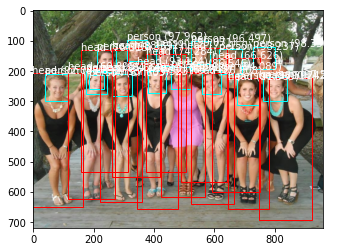

In [30]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)

The below code explains converting tf model to opevino IR format and inference in openvino runtime.
Please refer https://docs.openvino.ai/latest/openvino_docs_install_guides_install_dev_tools.html for openvino runtime

In [3]:
# converting model using openvino model optimizer
!mo --saved_model_dir bialcrowdv4 --input_shape [1,608,608,3] 

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/mnt/d/Queue_managment_debug/Yolov-4-master/Github backup/CROWD-PERSON-DETECTION/.
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,608,608,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force the usage of new Front

In [12]:
#Inference on converted model uisng openvino runtime
import openvino.runtime as ov
core = ov.Core()
model_name = "saved_model.xml"
model = core.compile_model(model_name, "AUTO")
input_layer = next(iter(model.inputs))
print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")
output_layer = next(iter(model.outputs))
print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

infer_request = model.create_infer_request()
#Create tensor from external memory
input_tensor = ov.Tensor(array=image, shared_memory=True)
# Set input tensor for model with one input
infer_request.set_input_tensor(input_tensor)
infer_request.start_async()
infer_request.wait()
# Get output tensor for model with one output
ypredict_open = []
output = infer_request.get_output_tensor(0)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(1)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(2)
output_buffer = output.data
ypredict_open.append(output_buffer)
[print(a.shape) for a in ypredict_open]
# output_buffer[] - accessing output tensor data

input precision: <Type: 'float32'>
input shape: {1, 608, 608, 3}
output precision: <Type: 'float32'>
output shape: {1, 76, 76, 21}
(1, 76, 76, 21)
(1, 38, 38, 21)
(1, 19, 19, 21)


[None, None, None]

Openvino support integrating preprocess step inside openvino IR.Now we integrate preprocess inside our converted model
https://docs.openvino.ai/latest/openvino_docs_OV_UG_Preprocessing_Overview.html#

In [13]:

import openvino.runtime as ov
from openvino.preprocess import PrePostProcessor,ColorFormat,ResizeAlgorithm
from openvino.runtime import Layout, Type
from openvino.runtime.passes import Manager
core = ov.Core()
model = core.read_model("saved_model.xml")
h,w= 720,960
ppp = PrePostProcessor(model)
input_name= 'input_0'
ppp.input(input_name).tensor() \
        .set_element_type(Type.u8) \
        .set_shape([1, h, w, 3]) \
        .set_layout(Layout('NHWC')) \
        .set_color_format(ColorFormat.RGB)

ppp.input(input_name).preprocess() \
    .convert_element_type(Type.f32) \
    .convert_color(ColorFormat.RGB) \
    .resize(ResizeAlgorithm.RESIZE_LINEAR) \
    .scale(255)
print(f'Dump preprocessor: {ppp}')
model = ppp.build()
pass_manager = Manager()
pass_manager.register_pass(pass_name="Serialize",
                           xml_path='saved_model_preprocess.xml',
                           bin_path='saved_model_preprocess.bin')
pass_manager.run_passes(model)

Dump preprocessor: Input "Func/StatefulPartitionedCall/input/_0:0" (color RGB):
    User's input tensor: {1,720,960,3}, [N,H,W,C], u8
    Model's expected tensor: {1,608,608,3}, [N,H,W,C], f32
    Pre-processing steps (4):
      convert type (f32): ({1,720,960,3}, [N,H,W,C], u8, RGB) -> ({1,720,960,3}, [N,H,W,C], f32, RGB)
      convert color (RGB): ({1,720,960,3}, [N,H,W,C], f32, RGB) -> ({1,720,960,3}, [N,H,W,C], f32, RGB)
      resize to model width/height: ({1,720,960,3}, [N,H,W,C], f32, RGB) -> ({1,608,608,3}, [N,H,W,C], f32, RGB)
      scale (255): ({1,608,608,3}, [N,H,W,C], f32, RGB) -> ({1,608,608,3}, [N,H,W,C], f32, RGB)



In [14]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
image = load_img('images/0004.jpg')
image = img_to_array(image)
image = expand_dims(image, 0)
image = image.astype('uint8')
print(image.dtype)

uint8


In [15]:
# Running inference on inegrated model
import openvino.runtime as ov
core = ov.Core()
model_name = "saved_model_preprocess.xml"
model = core.compile_model(model_name, "AUTO")
input_layer = next(iter(model.inputs))
print(f"input precision: {input_layer.element_type}")
print(f"input shape: {input_layer.shape}")
output_layer = next(iter(model.outputs))
print(f"output precision: {output_layer.element_type}")
print(f"output shape: {output_layer.shape}")

infer_request = model.create_infer_request()
#Create tensor from external memory
input_tensor = ov.Tensor(array=image, shared_memory=True)
# Set input tensor for model with one input
infer_request.set_input_tensor(input_tensor)
infer_request.start_async()
infer_request.wait()
# Get output tensor for model with one output
ypredict_open = []
output = infer_request.get_output_tensor(0)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(1)
output_buffer = output.data
ypredict_open.append(output_buffer)
output = infer_request.get_output_tensor(2)
output_buffer = output.data
ypredict_open.append(output_buffer)
[print(a.shape) for a in ypredict_open]

input precision: <Type: 'uuint8_t8'>
input shape: {1, 720, 960, 3}
output precision: <Type: 'float32'>
output shape: {1, 76, 76, 21}
(1, 76, 76, 21)
(1, 38, 38, 21)
(1, 19, 19, 21)


[None, None, None]

In [17]:
yhat=[ypredict_open[0],ypredict_open[1],ypredict_open[2]]